In [2]:
import re
import math
import scipy
import scipy.constants
def stokes_factor(nu_cm, I_raman, T=300.0):

    hc = scipy.constants.Planck*scipy.constants.speed_of_light*100.0 #J·cm
    kb = scipy.constants.Boltzmann
    
    x = nu_cm*hc / (kb*T)  
    n_bar = 1.0 / (math.exp(x) - 1.0)  # Bose-Einstein factor
    laser_factor = math.pow((15600.0-nu_cm)/15600.0, 4)
    return ((n_bar + 1.0) / nu_cm) * I_raman * laser_factor


def extract_frequencies(file_path):
    frequencies = []
    intensities = []
    ir_freq = []
    ir_intes = []
    activities = []
    irreps = []
    in_table = False
    
    with open(file_path, 'r') as file:
        for line in file:
            # table start
            if "Vibrational Frequencies" in line:
                in_table = True
                continue
            
            # table end
            if in_table and "." * 70 in line:
                in_table = False
            
            if in_table:
                parts = line.split()
                if len(parts) == 9:
                    if parts[7] == 'Y':
                        freq = float(parts[2])
                        activity = float(parts[6])
                        intensity = stokes_factor(freq, activity)
                        frequencies.append(freq)
                        intensities.append(intensity)
                        activities.append(activity)
                        irreps.append(parts[3])
                    if parts[5] == 'Y':
                        ir_freq.append(float(parts[2]))
                        ir_intes.append(float(parts[4]))
    return frequencies, intensities, activities, irreps, ir_freq, ir_intes
import os 
filename = 'dfpt_freq.txt'
frequencies, intensities, activities, irreps, ir_freq, ir_intens = extract_frequencies(filename)

print("Extracted Activities:", activities)
print("Extracted Frequencies:", frequencies)
print("Extracted Intensities:", intensities)

print("Extracted IR frequencies:", ir_freq)
print("Extracted IR intensities:", ir_intens)
print("Irreps: ", irreps)

Extracted Activities: [0.0027867, 0.0027963, 0.0027971, 5.146169, 5.1458927, 5.145884, 11.0070495, 11.008312, 11.0082544, 2.4130946, 10.5665677, 10.5666251, 2.1299529, 2.1304577, 2.1301853, 9.6734909, 9.6735877, 101.7845333, 17.5364364, 17.5342775, 17.5354598, 5.3799169, 5.37942, 5.3800262, 0.2820386, 0.2820719, 0.2820203, 53.7914736, 53.7935018, 3.1769412, 3.1769065, 3.1765447, 15.0923676, 15.0937375, 15.0911069, 113.439444, 222.9485667, 11.5250721, 11.5245135, 11.5244846, 12.7740188, 12.7744547, 12.773617, 40.438407, 40.4359204, 40.4355706, 1.4642944, 1.4640284, 1.4646596, 90.5248005, 90.5212308, 1284.6415409, 0.3132089, 0.3129353, 0.3128514, 0.3343584, 0.3346841, 0.3346214, 5.299854, 5.2990094, 3143.8599262, 8.0588609, 8.0597841, 8.0600984, 10.7562136, 10.755803, 53.0210209, 53.0273745, 53.0283747, 4.0504446, 4.0500431, 4.050126, 3.2160412, 3.2155672, 3.2152899, 193.6738814, 193.6819219, 69.5939857, 69.5952886, 69.5873738, 11.8632893, 11.8619204, 11.8651833, 4649.1014, 3.9522704, 3.

In [3]:
import re
def extract_mode_data(file_path):
    mode_data = {}
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    i = 0
    while i < len(lines):
        line = lines[i]
        if "Mode number:" in line:
            mode_match = re.search(r"Mode number:\s*(\d+)", line)
            if mode_match:
                mode = int(mode_match.group(1))
                matrix = []
                depolarisation_ratio = None
                for j in range(i+1, i+4):
                    row_line = lines[j]
                    numbers = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", row_line)
                    if j == i+1:
                        if len(numbers) >= 4:
                            depolarisation_ratio = float(numbers[3])
                        row = [float(x) for x in numbers[:3]]
                    else:
                        row = [float(x) for x in numbers[:3]]
                    matrix.append(row)
                mode_data[mode] = {"matrix": matrix, "depolarisation_ratio": depolarisation_ratio}
                i += 4
                continue
        i += 1

    return mode_data

polar_tensors = extract_mode_data("input\\polar_tensors.txt")

In [4]:
import pandas as pd 
def calculate_IRam(A):
    dic = {}
    alpha = ((A[0][0] + A[1][1] + A[2][2]) / 3.0)**2

    diag_diff = 0.5 * ((A[0][0]-A[1][1])**2+(A[1][1]-A[2][2])**2+(A[2][2]-A[0][0])**2)
    beta = diag_diff + 3.0 * (A[0][1]**2 + A[0][2]**2 + A[1][2]**2)
    
    gamma = diag_diff + 0.75*((A[0][1]+A[1][0])**2+(A[0][2]+A[2][0])**2+(A[2][1]+A[1][2])**2)
    delta = 0.75*((A[0][1]-A[1][0])**2+(A[0][2]-A[2][0])**2+(A[2][1]-A[1][2])**2)
    
    porezag = 45*alpha + 7*beta
    walter = 45*alpha + 7*gamma + 5*delta
    return {"alpha":alpha, "beta":beta, "gamma":gamma, "delta":delta, "porezag":porezag, "walter":walter}

rows = []
for mode, info in sorted(polar_tensors.items()):
        if int(mode) > 3:
            row = calculate_IRam(info["matrix"])
            row["mode"] = f"{int(mode)}"
            row["freq"] = frequencies[int(mode)-1-3]
            row["iram(castep)"]=activities[int(mode)-1-3]
            row["factor"]= "{:.4f}".format(row["iram(castep)"]/row["porezag"])
            row["irrep"] = irreps[int(mode)-1-3]
            row["fval"]= row["iram(castep)"]/row["porezag"]
            row["porezag_stokes"] = stokes_factor(row["freq"], row["porezag"])
            rows.append(row)
iram = pd.DataFrame(rows)
print("Porezag (1996) = 45*alpha + 7*beta")
print("Walter (2019) = 45*alpha + 7*gamma + 5*delta")
print("Porezag (stokes): I*(1+ni)/frequency, where ni = 1/(exp(frequency*h/kbT)-1)")
mean, std = iram['fval'].mean(), iram['fval'].std()

print(f"Mean factor: {mean:2f}, Factor deviation: {std:2f}")

pd.set_option('display.max_rows', None)

iram.insert(0, "mode", iram.pop("mode"))
iram.insert(0, "freq", iram.pop("freq"))
iram['porezag_stokes'] = iram['porezag_stokes']*mean
porezag = iram['porezag_stokes'].to_numpy()
iram.pop("fval")
iram.style.hide(axis="index")
iram

Porezag (1996) = 45*alpha + 7*beta
Walter (2019) = 45*alpha + 7*gamma + 5*delta
Porezag (stokes): I*(1+ni)/frequency, where ni = 1/(exp(frequency*h/kbT)-1)
Mean factor: 544.286802, Factor deviation: 11.055286


,freq,mode,alpha,beta,gamma,delta,porezag,walter,iram(castep),factor,irrep,porezag_stokes
0,45.215501,4,0.000000e+00,7.500000e-07,7.500000e-07,0.0,0.000005,0.000005,0.002787,530.8000,a,0.000320
1,45.215501,5,0.000000e+00,8.700000e-07,8.700000e-07,0.0,0.000006,0.000006,0.002796,459.1626,a,0.000372
2,45.215501,6,0.000000e+00,6.600000e-07,6.600000e-07,0.0,0.000005,0.000005,0.002797,605.4329,a,0.000282
3,52.597421,7,0.000000e+00,1.346490e-03,1.346490e-03,0.0,0.009425,0.009425,5.146169,545.9877,a,0.431605
4,52.597421,8,0.000000e+00,1.348920e-03,1.348920e-03,0.0,0.009442,0.009442,5.145893,544.9749,a,0.432384
5,52.597421,9,0.000000e+00,1.351530e-03,1.351530e-03,0.0,0.009461,0.009461,5.145884,543.9215,a,0.433220
6,56.120118,10,0.000000e+00,2.889900e-03,2.889900e-03,0.0,0.020229,0.020229,11.007050,544.1142,a,0.819546
7,56.120118,11,0.000000e+00,2.880900e-03,2.880900e-03,0.0,0.020166,0.020166,11.008312,545.8766,a,0.816994
8,56.120118,12,0.000000e+00,2.883180e-03,2.883180e-03,0.0,0.020182,0.020182,11.008254,545.4421,a,0.817640
9,61.640431,13,9.801000e-05,0.000000e+00,0.000000e+00,0.0,0.004410,0.004410,2.413095,547.1312,b,0.149776


[45.215501, 45.215501, 45.215501, 52.597421, 52.597421, 52.597421, 56.120118, 56.120118, 56.120118, 61.640431, 67.918822, 67.918822, 84.692793, 84.692793, 84.692793, 85.207996, 85.207996, 86.271004, 95.327714, 95.327714, 95.327714, 103.985153, 103.985153, 103.985153, 105.84268, 105.84268, 105.84268, 123.242607, 123.242607, 123.902749, 123.902749, 123.902749, 133.801939, 133.801939, 133.801939, 143.461409, 164.538659, 171.437488, 171.437488, 171.437488, 187.32576, 187.32576, 187.32576, 212.413334, 212.413334, 212.413334, 226.2259, 226.2259, 226.2259, 243.241991, 243.241991, 278.418221, 284.712247, 284.712247, 284.712247, 313.756159, 313.756159, 313.756159, 330.645604, 330.645604, 336.066625, 358.626798, 358.626798, 358.626798, 365.369386, 365.369386, 371.540517, 371.540517, 371.540517, 447.266608, 447.266608, 447.266608, 468.640152, 468.640152, 468.640152, 477.118887, 477.118887, 496.164308, 496.164308, 496.164308, 530.735009, 530.735009, 530.735009, 556.550485, 561.701883, 561.701883, 

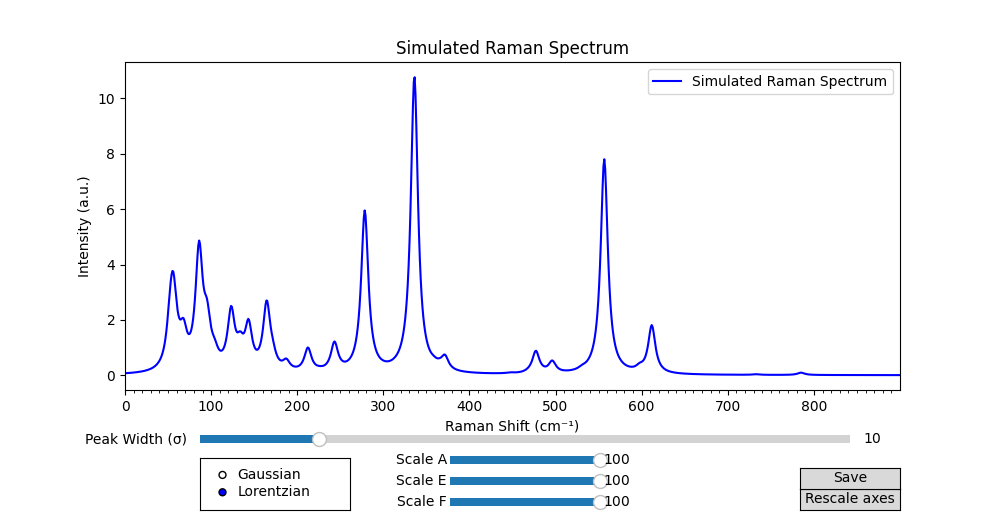

In [6]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
from matplotlib.widgets import RadioButtons
import math 

def gaussian(x, x0, I0, sigma):
    return I0 * np.exp(-((x - x0) ** 2) / (sigma ** 2))

def lorentzian(x, x0, I0, gamma):
    return I0 / (1 + ((x - x0) / (gamma*0.5)) ** 2)

# Generate Raman spectrum
def generate_raman_spectrum(peaks, intensities, sigma=5, scalea=100, scalee=100, scalef=100, x_range=(0, 900), num_points=900, radioVal = 'Lorentzian'):
    #max_intensity = max(intensities)
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.zeros_like(x)
    for x0, I0, irr,I1 in zip(peaks, intensities, irreps,porezag):
        scale = 100 
        if irr == 'a':
            scale = scalef
        elif irr == 'b':
            scale = scalea
        elif irr == 'c':
            scale = scalee
        if radioVal == 'Gaussian':
            #y += gaussian(x, x0, (I0)*(scale/100.0), sigma/2 + sigma*(I0/(2*max_intensity)))
            y += gaussian(x, x0, (I0)*(scale/100.0), sigma)
        else:
            y += lorentzian(x, x0, (I0)*(scale/100.0), sigma)
    
    return x, y

def update_plot(val):
    sigma = sigma_slider.val  
    x_updated, y_updated= generate_raman_spectrum(frequencies, intensities, sigma=sigma, scalea=ascale_slider.val,
                                                    scalee= bscale_slider.val, scalef=cscale_slider.val, radioVal=radio.value_selected)

    line.set_ydata(y_updated)
    fig.canvas.draw_idle()  
    
def rescale(event):
    ax.set_ylim(min(line.get_ydata()), max(line.get_ydata())*1.1)
    ax.relim()  
    ax.autoscale_view()  
    #fig.autoscale()

def save(event):
    #save x,y to csv
    x, y = generate_raman_spectrum(frequencies, intensities, sigma=sigma_slider.val , scalea=ascale_slider.val,
                                                    scalee= bscale_slider.val, scalef=cscale_slider.val, radioVal=radio.value_selected)
    np.savetxt('raman.csv', np.column_stack((x, y)), delimiter=',', fmt='%.4f')
    

sigma_init = 10
# Generate and plot the spectrum
print(frequencies)
x, y= generate_raman_spectrum(frequencies, intensities, sigma_init, 100, 100,100)
fig,ax = plt.subplots(figsize=(1000 / 100, 520 / 100), dpi=100)
plt.subplots_adjust(bottom=0.25)
plt.xlim(0, 900)
line, = plt.plot(x, y, label="Simulated Raman Spectrum", color='b')

#plt.scatter(frequencies, intensities, color='r', label="Peak Positions")
plt.xlabel("Raman Shift (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Simulated Raman Spectrum")
major_ticks = np.arange(0, 900, step=100)
minor_ticks = np.arange(0, 900, step=10)
plt.xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
plt.legend()

ax_sigma = plt.axes([0.2, 0.14, 0.65, 0.03])  
ax_scale = plt.axes([0.45, 0.10, 0.15, 0.03])  
bx_scale = plt.axes([0.45, 0.06, 0.15, 0.03])  
cx_scale = plt.axes([0.45, 0.02, 0.15, 0.03])  

sigma_slider = Slider(ax_sigma, "Peak Width (σ)", 1, 50, valinit=sigma_init)
ascale_slider = Slider(ax_scale, "Scale A", 0, 100, valinit=100)
bscale_slider = Slider(bx_scale, "Scale E", 0, 100, valinit=100)
cscale_slider = Slider(cx_scale, "Scale F", 0, 100, valinit=100)
rax = plt.axes([0.2, 0.02, 0.15, 0.1])  # [left, bottom, width, height] in figure coordinates
radio = RadioButtons(rax, ('Gaussian', 'Lorentzian'), active=1)  # Default: lorenz

sigma_slider.on_changed(update_plot)
ascale_slider.on_changed(update_plot)
bscale_slider.on_changed(update_plot)
cscale_slider.on_changed(update_plot)
radio.on_clicked(update_plot)
ax_button = plt.axes([0.8, 0.02, 0.1, 0.04])  
button = Button(ax_button, 'Rescale axes')

button.on_clicked(rescale)
save_button = plt.axes([0.8, 0.06, 0.1, 0.04])  
saveButton = Button(save_button, 'Save')
saveButton.on_clicked(save)
button.on_clicked(rescale)
print(ax.get_ylim())
plt.show()

[45.215501, 45.215501, 45.215501, 52.597421, 52.597421, 52.597421, 56.120118, 56.120118, 56.120118, 61.640431, 67.918822, 67.918822, 84.692793, 84.692793, 84.692793, 85.207996, 85.207996, 86.271004, 95.327714, 95.327714, 95.327714, 103.985153, 103.985153, 103.985153, 105.84268, 105.84268, 105.84268, 123.242607, 123.242607, 123.902749, 123.902749, 123.902749, 133.801939, 133.801939, 133.801939, 143.461409, 164.538659, 171.437488, 171.437488, 171.437488, 187.32576, 187.32576, 187.32576, 212.413334, 212.413334, 212.413334, 226.2259, 226.2259, 226.2259, 243.241991, 243.241991, 278.418221, 284.712247, 284.712247, 284.712247, 313.756159, 313.756159, 313.756159, 330.645604, 330.645604, 336.066625, 358.626798, 358.626798, 358.626798, 365.369386, 365.369386, 371.540517, 371.540517, 371.540517, 447.266608, 447.266608, 447.266608, 468.640152, 468.640152, 468.640152, 477.118887, 477.118887, 496.164308, 496.164308, 496.164308, 530.735009, 530.735009, 530.735009, 556.550485, 561.701883, 561.701883, 

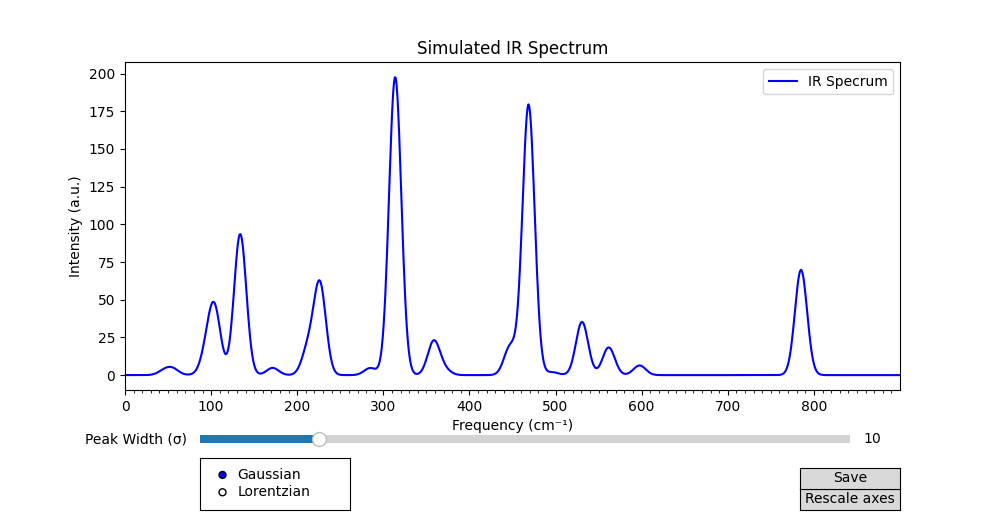

In [9]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.widgets import Button
from matplotlib.widgets import RadioButtons
import math 

def gaussian(x, x0, I0, sigma):
    return I0 * np.exp(-((x - x0) ** 2) / (sigma ** 2))

def lorentzian(x, x0, I0, gamma):
    return I0 / (1 + ((x - x0) / (gamma*0.5)) ** 2)

# Generate Raman spectrum
def generate_ir_spectrum(peaks, intensities, sigma=5, x_range=(0, 900), num_points=900, radioVal = 'Gaussian'):
    x = np.linspace(x_range[0], x_range[1], num_points)
    y = np.zeros_like(x)

    for x0, I0, irr in zip(peaks, intensities, irreps):
        
        if radioVal == 'Gaussian':
            #y += gaussian(x, x0, (I0)*(scale/100.0), sigma/2 + sigma*(I0/(2*max_intensity)))
            y += gaussian(x, x0, (I0), sigma)
        else:
            y += lorentzian(x, x0, (I0), sigma)
    
    return x, y

def update_plot(val):
    sigma = sigma_slider.val  
    x_updated, y_updated = generate_ir_spectrum(ir_freq, ir_intens, sigma=sigma, radioVal=radio.value_selected)

    line.set_ydata(y_updated)
    fig.canvas.draw_idle()  

def save(event):
    sigma = sigma_slider.val  
    x_updated, y_updated = generate_ir_spectrum(ir_freq, ir_intens, sigma=sigma, radioVal=radio.value_selected)
    np.savetxt('ir.csv', np.column_stack((x_updated, y_updated)), delimiter=',', fmt='%.4f')

def rescale():
    ax.set_ylim(min(line.get_ydata), max(line.get_ydata)+50)
    ax.relim()  
    ax.autoscale_view()  
    #fig.autoscale()

sigma_init = 10
# Generate and plot the spectrum
print(frequencies)
x, y = generate_ir_spectrum(ir_freq, ir_intens, sigma_init)
fig,ax = plt.subplots(figsize=(1000 / 100, 520 / 100), dpi=100)
plt.subplots_adjust(bottom=0.25)
plt.xlim(0, 900)
line, = plt.plot(x, y, label="IR Specrum", color='b')

#plt.scatter(frequencies, intensities, color='r', label="Peak Positions")
plt.xlabel("Frequency (cm⁻¹)")
plt.ylabel("Intensity (a.u.)")
plt.title("Simulated IR Spectrum")
major_ticks = np.arange(0, 900, step=100)
minor_ticks = np.arange(0, 900, step=10)
plt.xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
plt.legend()

ax_sigma = plt.axes([0.2, 0.14, 0.65, 0.03])  

sigma_slider = Slider(ax_sigma, "Peak Width (σ)", 1, 50, valinit=sigma_init)
rax = plt.axes([0.2, 0.02, 0.15, 0.1])  # [left, bottom, width, height] in figure coordinates
radio = RadioButtons(rax, ('Gaussian', 'Lorentzian'), active=0)  # Default: Gaussian

sigma_slider.on_changed(update_plot)
radio.on_clicked(update_plot)
ax_button = plt.axes([0.8, 0.02, 0.1, 0.04])  
button = Button(ax_button, 'Rescale axes')

button.on_clicked(rescale)

save_button = plt.axes([0.8, 0.06, 0.1, 0.04])  
saveButton = Button(save_button, 'Save')
saveButton.on_clicked(save)
button.on_clicked(rescale)
plt.show()

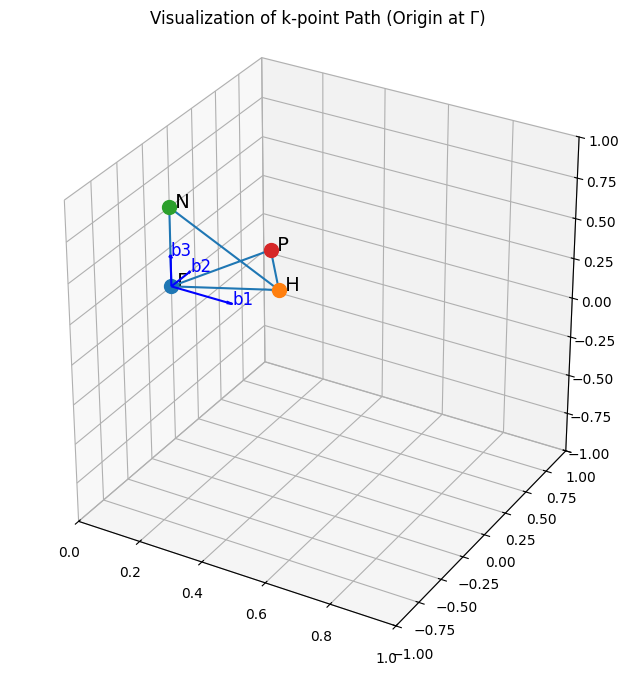

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

points = {
    "Γ": [0.0, 0.0, 0.0],
    "H": [0.5, -0.5, 0.5],
    "N": [0.0, 0.0, 0.5],
    "P": [0.25, 0.25, 0.25]
}

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for label, (x, y, z) in points.items():
    ax.scatter(x, y, z, marker='o', s=100)
    ax.text(x, y, z, f' {label}', size=14, zorder=1, color='k')

path_sequence = ["Γ", "H", "N", "Γ", "P", "H"]
path_coords = [points[label] for label in path_sequence]

x_path, y_path, z_path = zip(*path_coords)
ax.plot(x_path, y_path, z_path, linestyle='-', linewidth=1.5)
ax.set_xlim(0,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
axes_length = 0.2
ax.quiver(0, 0, 0, axes_length, 0, 0, color='b', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, axes_length, 0, color='b', arrow_length_ratio=0.1)
ax.quiver(0, 0, 0, 0, 0, axes_length, color='b', arrow_length_ratio=0.1)

ax.text(axes_length, 0, 0, 'b1', color='b', size=12)
ax.text(0, axes_length, 0, 'b2', color='b', size=12)
ax.text(0, 0, axes_length, 'b3', color='b', size=12)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')
ax.set_title('Visualization of k-point Path (Origin at Γ)')

ax.set_box_aspect([1, 1, 1])

plt.show()